In [ ]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data
from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision
import matplotlib.pyplot as plt
import time
from collections import namedtuple

from torchvision import transforms, datasets, models

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
#transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
transform = transforms.ToTensor()
train = MNIST('./data',train = True, transform=transform, download=True)

test = MNIST('./data',train = False, transform=transform, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
X_train = train.data
X_train = train.transform(X_train.numpy())

print('[Train Data]')
print(' - Numpy Shape:', X_train.cpu().numpy().shape)
print(' - Tensor Shape:', X_train.size())
print(' - min:', torch.min(X_train))
print(' - max:', torch.max(X_train))
print(' - mean:', torch.mean(X_train))
print(' - std:', torch.std(X_train))
print(' - var:', torch.var(X_train))


print('\n[Train Labels]')
print(' - Numpy Shape:', train.targets.cpu().numpy().shape)
print(' - Tensor Shape:', train.targets.size())

[Train Data]
 - Numpy Shape: (28, 60000, 28)
 - Tensor Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)

[Train Labels]
 - Numpy Shape: (60000,)
 - Tensor Shape: torch.Size([60000])


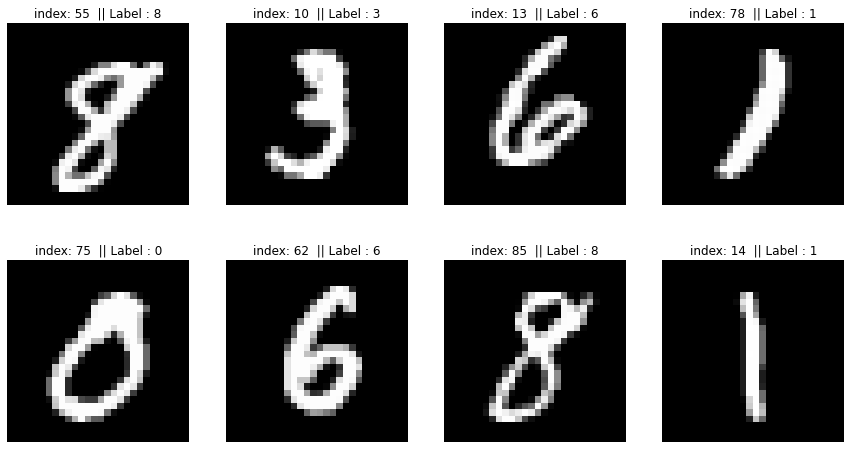

In [ ]:

indx  = np.random.randint(100,size=8)
_,pos = plt.subplots(2,4,figsize = (15,8))
for i in range(8):
  X = train.data[indx[i]]
  Y = train.targets[indx[i]]
  r,c = i // 4, i % 4
  pos[r][c].set_title("index: {}  || Label : {}".format(indx[i],Y))
  pos[r][c].axis("off")
  pos[r][c].imshow(X.numpy(),cmap = 'gray')
plt.show()
  

In [ ]:
##Creating own dataset example
class MyDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,index):
        X = self.X[index].float().reshape(-1)
        Y = self.Y[index].long()
        return X,Y

In [ ]:
train_size = int(0.8 * len(train.data))
val_size = len(train.data) - train_size
train_dataset = MyDataset(train.data, train.targets)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
num_workers = 8

test_dataset = MyDataset(test.data, test.targets)

train_loader_args = dict(shuffle=True, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=64)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

val_loader_args = dict(shuffle=True, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=64)
val_loader = data.DataLoader(val_dataset, **val_loader_args)

test_loader_args = dict(shuffle=False, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_loader = data.DataLoader(test_dataset, **test_loader_args)


Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])

In [ ]:
#Defining a Simple MLP model
class MyModel(nn.Module):
  def __init__(self,size_list):
    super(MyModel, self).__init__()
    self.size_list = size_list
    layers = []
    for i in range(len(size_list)-2):
      layers.append(nn.Linear(size_list[i],size_list[i+1]))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout())
    layers.append(nn.Linear(size_list[-2],size_list[-1]))
    self.net = nn.Sequential(*layers)
    # self.layers  = nn.ModuleList(self.layers)
  
  def forward(self,x):
    return self.net(x)


In [ ]:
model = MyModel([784,256,256,10])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

MyModel(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
def train_epoch(model,train_loader,criterion,optimizer):
  model.train()
  running_loss = 0.0
  start_time = time.time()
  for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
  end_time = time.time()
  running_loss /= len(train_loader)
  print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
  return running_loss
  

In [ ]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            #_, predicted = torch.max(outputs, 1)
            #_, predicted = torch.max(outputs.data, 1)
            predicted = torch.argmax(outputs,dim = 1)

            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()
            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [ ]:
n_epochs = 25
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

Training Loss:  1.3132261673503733 Time:  2.446396827697754 s
Testing Loss:  0.27945166495628654
Testing Accuracy:  92.69 %
Training Loss:  0.4675564620089024 Time:  2.4577431678771973 s
Testing Loss:  0.2313057843130082
Testing Accuracy:  94.23 %
Training Loss:  0.36788570246797925 Time:  2.4063210487365723 s
Testing Loss:  0.20378063218668102
Testing Accuracy:  95.05 %
Training Loss:  0.3129658827439268 Time:  2.4044833183288574 s
Testing Loss:  0.16671632630750538
Testing Accuracy:  95.44 %
Training Loss:  0.28974246566599987 Time:  2.4180736541748047 s
Testing Loss:  0.17937852563336493
Testing Accuracy:  95.44 %
Training Loss:  0.2560564568068119 Time:  2.397829055786133 s
Testing Loss:  0.15766099314205348
Testing Accuracy:  96.0 %
Training Loss:  0.244768194774998 Time:  2.3868401050567627 s
Testing Loss:  0.15065158884972335
Testing Accuracy:  95.95 %
Training Loss:  0.2338283849444161 Time:  2.3874685764312744 s
Testing Loss:  0.15342355058528484
Testing Accuracy:  95.86 %
Tra

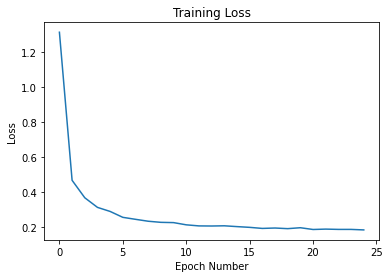

In [ ]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)

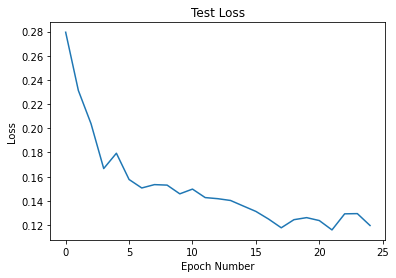

In [ ]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Test_loss)


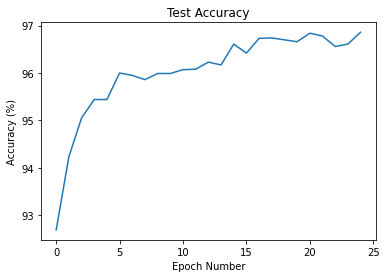

In [ ]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)



